In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Caminho base para a pasta 'data'
base_path = os.path.join(os.getcwd(), 'data')

# Lista de exchanges para testar
exchanges = ['binance', 'bybit']  # Agora suportamos ambas

# Lista de ativos e timeframes disponíveis
assets = ['BTCUSDT', 'SOLUSDT', 'ETHUSDT']
timeframes = ['1H', '4H', '1D']

# Configuração das Médias Móveis por timeframe
ma_settings = {
    '1H': {'ma_short': 20, 'ma_long': 50},
    '4H': {'ma_short': 40, 'ma_long': 100},
    '1D': {'ma_short': 50, 'ma_long': 200}
}

# Features a serem usadas no modelo
selected_features = ['ATR', 'Volume', 'BB Upper Band', 'ADX', 
                     'Simple Moving Average', 'BB Basis', 
                     'BB Lower Band', 'RSI', 'Histogram', 'MACD Line']


In [27]:
def process_asset_timeframe(asset, timeframe):
    # Construir o caminho correto do arquivo
    file_path = os.path.join(base_path, f'binance/{timeframe.lower()}/{asset.lower()}.csv')
    
    # Verificar se o arquivo existe
    if not os.path.exists(file_path):
        print(f"❌ Arquivo não encontrado: {file_path}")
        return None

    print(f"\n📊 Processando {asset} {timeframe}...")

    # Carregar os dados
    df = pd.read_csv(file_path)

    # Ajustar parâmetros do timeframe
    ma_short = ma_settings[timeframe]['ma_short']
    ma_long = ma_settings[timeframe]['ma_long']

    # Aplicar lógica de Médias Móveis
    df = df.copy()
    df['ma_short'] = df['close'].rolling(ma_short).mean()
    df['ma_long'] = df['close'].rolling(ma_long).mean()
    df['trend_ma'] = 1  # Lateral padrão
    df.loc[(df['close'] > df['ma_long']) & (df['ma_short'] > df['ma_long']), 'trend_ma'] = 2  # Alta
    df.loc[(df['close'] < df['ma_long']) & (df['ma_short'] < df['ma_long']), 'trend_ma'] = 0  # Baixa
    df.drop(columns=['ma_short', 'ma_long'], inplace=True)  # Remover colunas auxiliares

    return df

In [28]:
def train_and_evaluate(asset, timeframe, df):
    print(f"\n🚀 Treinando modelo para {asset} {timeframe}...")

    # Selecionar features e target
    X = df[selected_features]
    y = df['trend_ma']

    # Garantir que há pelo menos 2 classes no dataset
    if y.nunique() < 2:
        print(f"⚠️ Dados insuficientes para {asset} {timeframe} (somente {y.nunique()} classes detectadas). Pulando...")
        return None

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Aplicar SMOTE para balanceamento
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Treinar modelo XGBoost
    model = XGBClassifier(eval_metric='mlogloss', verbosity=0)
    model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = model.predict(X_test)

    # Avaliação do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f"✅ {asset} {timeframe} - Acurácia: {accuracy:.4f}")

    # Exibir relatório de classificação completo
    report = classification_report(y_test, y_pred, target_names=["0 (Baixa)", "1 (Lateral)", "2 (Alta)"])
    print("\n📊 📌 Classification Report:")
    print(report)

    # Criar Matriz de Confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["0 (Baixa)", "1 (Lateral)", "2 (Alta)"],
                yticklabels=["0 (Baixa)", "1 (Lateral)", "2 (Alta)"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - {asset} {timeframe}")
    plt.show()

    return {
        "model": model,
        "accuracy": accuracy,
        "classification_report": report
    }

In [29]:
results = {}

for exchange in exchanges:  # Agora percorremos Binance e Bybit
    for asset in assets:
        for timeframe in timeframes:
            # Construir caminho do arquivo para Binance e Bybit
            file_path = os.path.join(base_path, f'{exchange}/{timeframe.lower()}/{asset.lower()}.csv')

            # Verificar se o arquivo existe
            if not os.path.exists(file_path):
                print(f"❌ Arquivo não encontrado: {file_path}")
                continue

            print(f"\n📊 Processando {exchange.upper()} - {asset} {timeframe}...")

            # Carregar os dados
            df = pd.read_csv(file_path)

            # Ajustar parâmetros do timeframe
            ma_short = ma_settings[timeframe]['ma_short']
            ma_long = ma_settings[timeframe]['ma_long']

            # Aplicar lógica de Médias Móveis
            df = df.copy()
            df['ma_short'] = df['close'].rolling(ma_short).mean()
            df['ma_long'] = df['close'].rolling(ma_long).mean()
            df['trend_ma'] = 1  # Lateral padrão
            df.loc[(df['close'] > df['ma_long']) & (df['ma_short'] > df['ma_long']), 'trend_ma'] = 2  # Alta
            df.loc[(df['close'] < df['ma_long']) & (df['ma_short'] < df['ma_long']), 'trend_ma'] = 0  # Baixa
            df.drop(columns=['ma_short', 'ma_long'], inplace=True)  # Remover colunas auxiliares

            results[f"{exchange.upper()}_{asset}_{timeframe}"] = df




📊 Processando BINANCE - BTCUSDT 1H...

📊 Processando BINANCE - BTCUSDT 4H...

📊 Processando BINANCE - BTCUSDT 1D...

📊 Processando BINANCE - SOLUSDT 1H...

📊 Processando BINANCE - SOLUSDT 4H...

📊 Processando BINANCE - SOLUSDT 1D...

📊 Processando BINANCE - ETHUSDT 1H...

📊 Processando BINANCE - ETHUSDT 4H...

📊 Processando BINANCE - ETHUSDT 1D...

📊 Processando BYBIT - BTCUSDT 1H...

📊 Processando BYBIT - BTCUSDT 4H...

📊 Processando BYBIT - BTCUSDT 1D...

📊 Processando BYBIT - SOLUSDT 1H...

📊 Processando BYBIT - SOLUSDT 4H...

📊 Processando BYBIT - SOLUSDT 1D...

📊 Processando BYBIT - ETHUSDT 1H...

📊 Processando BYBIT - ETHUSDT 4H...

📊 Processando BYBIT - ETHUSDT 1D...


In [30]:
cleaned_results = {}

for key, df in results.items():
    # Remover colunas com muitos NaN
    cols_to_drop = df.columns[df.isna().mean() > 0.5]  # Remove colunas com +50% de NaN
    
    if len(cols_to_drop) > 0:
        print(f"⚠️ {key} - Removendo colunas: {list(cols_to_drop)}")

    df_clean = df.drop(columns=cols_to_drop)

    # Remover linhas restantes com NaN
    df_clean = df_clean.dropna()

    # Se ainda houver dados suficientes, adicionar ao conjunto limpo
    if df_clean.empty:
        print(f"❌ {key} - Dados insuficientes após limpeza. Pulando...")
        continue

    cleaned_results[key] = df_clean

⚠️ BINANCE_BTCUSDT_1H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_BTCUSDT_4H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_BTCUSDT_1D - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_SOLUSDT_1H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_SOLUSDT_4H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_SOLUSDT_1D - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_ETHUSDT_1H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_ETHUSDT_4H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BINANCE_ETHUSDT_1D - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BYBIT_BTCUSDT_1H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BYBIT_BTCUSDT_4H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BYBIT_BTCUSDT_1D - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BYBIT_SOLUSDT_1H - Removendo colunas: ['Bids Volume', 'Asks Volume']
⚠️ BYBIT_SOLUSDT_4H - Removendo colunas: ['Bid


🚀 Iniciando treino para BINANCE - BTCUSDT 1H (Total de 44606 linhas)...

🚀 Treinando modelo para BTCUSDT 1H...
✅ BTCUSDT 1H - Acurácia: 0.8945

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.95      0.90      0.92      3307
 1 (Lateral)       0.69      0.84      0.76      1690
    2 (Alta)       0.96      0.92      0.94      3925

    accuracy                           0.89      8922
   macro avg       0.87      0.89      0.87      8922
weighted avg       0.91      0.89      0.90      8922



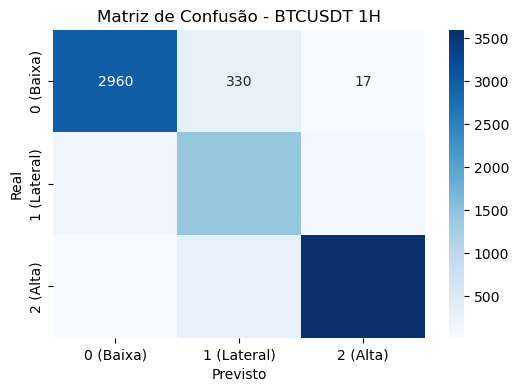


🚀 Iniciando treino para BINANCE - BTCUSDT 4H (Total de 11801 linhas)...

🚀 Treinando modelo para BTCUSDT 4H...
✅ BTCUSDT 4H - Acurácia: 0.9157

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.93      0.93      0.93       824
 1 (Lateral)       0.80      0.85      0.83       467
    2 (Alta)       0.96      0.93      0.95      1070

    accuracy                           0.92      2361
   macro avg       0.90      0.91      0.90      2361
weighted avg       0.92      0.92      0.92      2361



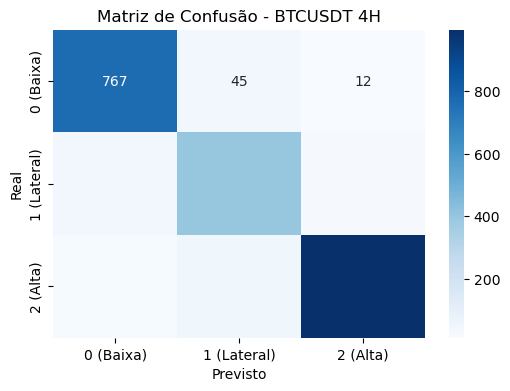


🚀 Iniciando treino para BINANCE - BTCUSDT 1D (Total de 1927 linhas)...

🚀 Treinando modelo para BTCUSDT 1D...
✅ BTCUSDT 1D - Acurácia: 0.9819

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       1.00      0.96      0.98       109
 1 (Lateral)       0.92      0.99      0.95        74
    2 (Alta)       1.00      0.99      0.99       203

    accuracy                           0.98       386
   macro avg       0.97      0.98      0.98       386
weighted avg       0.98      0.98      0.98       386



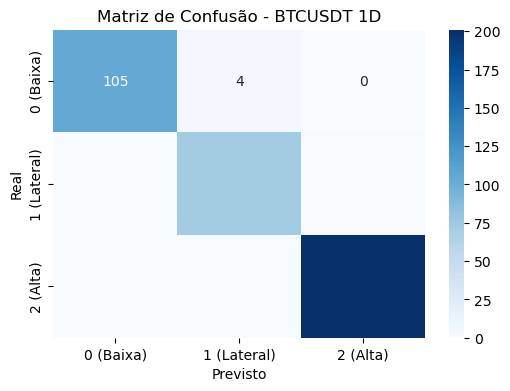


🚀 Iniciando treino para BINANCE - SOLUSDT 1H (Total de 38431 linhas)...

🚀 Treinando modelo para SOLUSDT 1H...
✅ SOLUSDT 1H - Acurácia: 0.9066

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.96      0.91      0.94      3134
 1 (Lateral)       0.72      0.86      0.78      1456
    2 (Alta)       0.96      0.92      0.94      3097

    accuracy                           0.91      7687
   macro avg       0.88      0.90      0.89      7687
weighted avg       0.92      0.91      0.91      7687



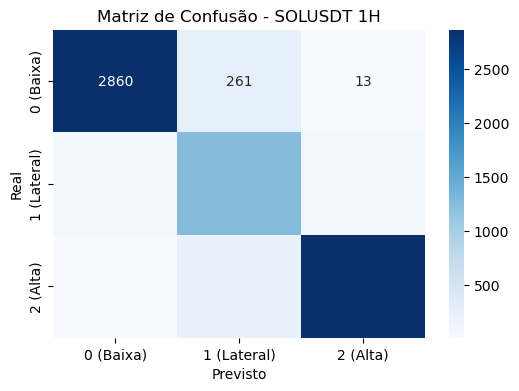


🚀 Iniciando treino para BINANCE - SOLUSDT 4H (Total de 9572 linhas)...

🚀 Treinando modelo para SOLUSDT 4H...
✅ SOLUSDT 4H - Acurácia: 0.8830

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.95      0.90      0.92       753
 1 (Lateral)       0.69      0.82      0.75       347
    2 (Alta)       0.93      0.89      0.91       815

    accuracy                           0.88      1915
   macro avg       0.85      0.87      0.86      1915
weighted avg       0.89      0.88      0.89      1915



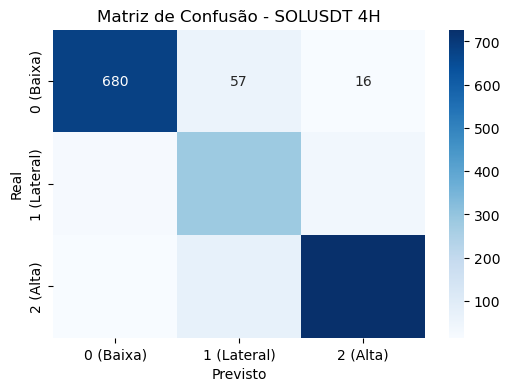


🚀 Iniciando treino para BINANCE - SOLUSDT 1D (Total de 1555 linhas)...

🚀 Treinando modelo para SOLUSDT 1D...
✅ SOLUSDT 1D - Acurácia: 0.9550

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.97      0.98      0.97        98
 1 (Lateral)       0.89      0.92      0.91        64
    2 (Alta)       0.97      0.95      0.96       149

    accuracy                           0.95       311
   macro avg       0.95      0.95      0.95       311
weighted avg       0.96      0.95      0.96       311



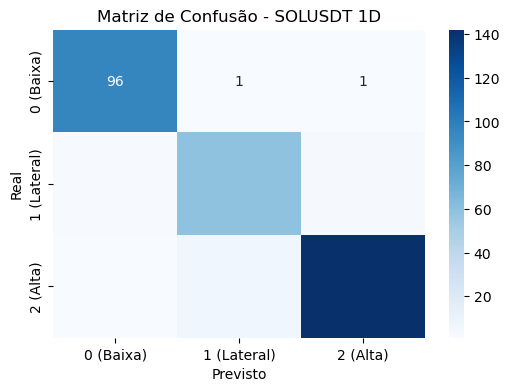


🚀 Iniciando treino para BINANCE - ETHUSDT 1H (Total de 44606 linhas)...

🚀 Treinando modelo para ETHUSDT 1H...
✅ ETHUSDT 1H - Acurácia: 0.8970

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.95      0.91      0.93      3325
 1 (Lateral)       0.70      0.84      0.76      1713
    2 (Alta)       0.96      0.92      0.94      3884

    accuracy                           0.90      8922
   macro avg       0.87      0.89      0.88      8922
weighted avg       0.91      0.90      0.90      8922



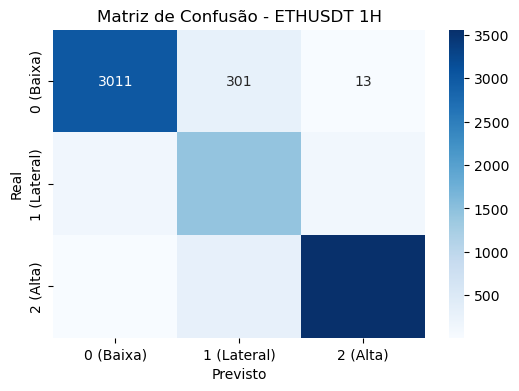


🚀 Iniciando treino para BINANCE - ETHUSDT 4H (Total de 11324 linhas)...

🚀 Treinando modelo para ETHUSDT 4H...
✅ ETHUSDT 4H - Acurácia: 0.9002

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.95      0.89      0.92       829
 1 (Lateral)       0.70      0.86      0.78       398
    2 (Alta)       0.96      0.92      0.94      1038

    accuracy                           0.90      2265
   macro avg       0.87      0.89      0.88      2265
weighted avg       0.91      0.90      0.90      2265



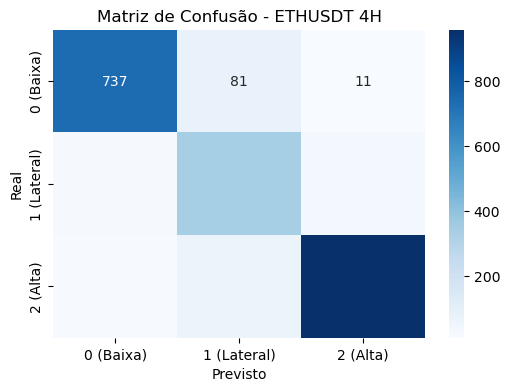


🚀 Iniciando treino para BINANCE - ETHUSDT 1D (Total de 1847 linhas)...

🚀 Treinando modelo para ETHUSDT 1D...
✅ ETHUSDT 1D - Acurácia: 0.9703

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.99      0.95      0.97        99
 1 (Lateral)       0.90      0.92      0.91        61
    2 (Alta)       0.98      1.00      0.99       210

    accuracy                           0.97       370
   macro avg       0.96      0.95      0.96       370
weighted avg       0.97      0.97      0.97       370



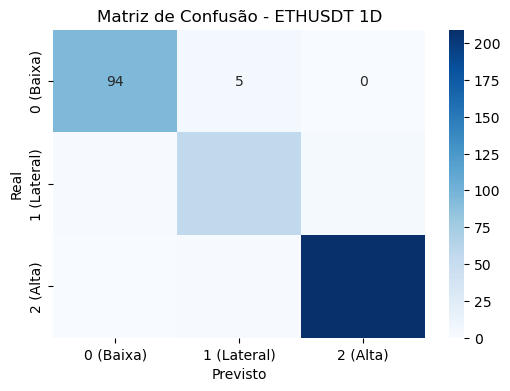


🚀 Iniciando treino para BYBIT - BTCUSDT 1H (Total de 42580 linhas)...

🚀 Treinando modelo para BTCUSDT 1H...
✅ BTCUSDT 1H - Acurácia: 0.9001

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.95      0.91      0.93      3164
 1 (Lateral)       0.71      0.85      0.77      1599
    2 (Alta)       0.96      0.92      0.94      3753

    accuracy                           0.90      8516
   macro avg       0.87      0.89      0.88      8516
weighted avg       0.91      0.90      0.90      8516



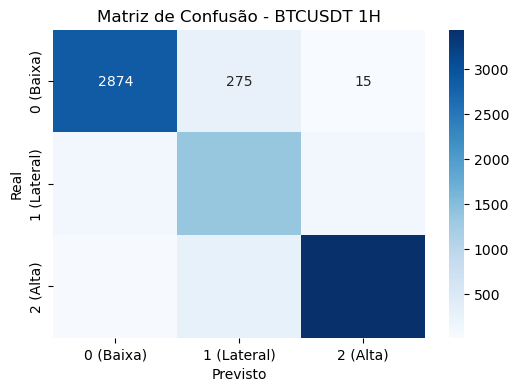


🚀 Iniciando treino para BYBIT - BTCUSDT 4H (Total de 10609 linhas)...

🚀 Treinando modelo para BTCUSDT 4H...
✅ BTCUSDT 4H - Acurácia: 0.9166

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.93      0.92      0.92       720
 1 (Lateral)       0.81      0.84      0.83       429
    2 (Alta)       0.96      0.94      0.95       973

    accuracy                           0.92      2122
   macro avg       0.90      0.90      0.90      2122
weighted avg       0.92      0.92      0.92      2122



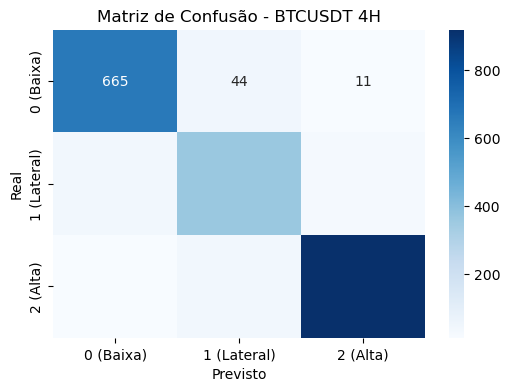


🚀 Iniciando treino para BYBIT - BTCUSDT 1D (Total de 1728 linhas)...

🚀 Treinando modelo para BTCUSDT 1D...
✅ BTCUSDT 1D - Acurácia: 0.9624

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.99      0.97      0.98       103
 1 (Lateral)       0.87      0.96      0.91        69
    2 (Alta)       0.99      0.96      0.97       174

    accuracy                           0.96       346
   macro avg       0.95      0.96      0.95       346
weighted avg       0.96      0.96      0.96       346



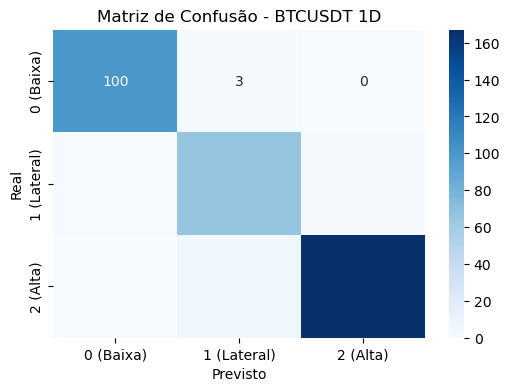


🚀 Iniciando treino para BYBIT - SOLUSDT 1H (Total de 31519 linhas)...

🚀 Treinando modelo para SOLUSDT 1H...
✅ SOLUSDT 1H - Acurácia: 0.9129

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.97      0.92      0.95      2603
 1 (Lateral)       0.73      0.87      0.80      1196
    2 (Alta)       0.96      0.92      0.94      2505

    accuracy                           0.91      6304
   macro avg       0.89      0.90      0.89      6304
weighted avg       0.92      0.91      0.92      6304



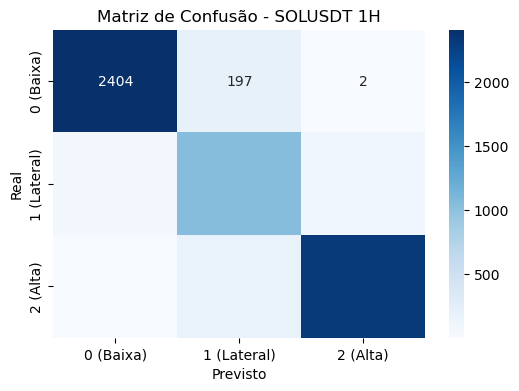


🚀 Iniciando treino para BYBIT - SOLUSDT 4H (Total de 7844 linhas)...

🚀 Treinando modelo para SOLUSDT 4H...
✅ SOLUSDT 4H - Acurácia: 0.8974

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.94      0.92      0.93       641
 1 (Lateral)       0.72      0.84      0.78       295
    2 (Alta)       0.95      0.90      0.93       633

    accuracy                           0.90      1569
   macro avg       0.87      0.89      0.88      1569
weighted avg       0.91      0.90      0.90      1569



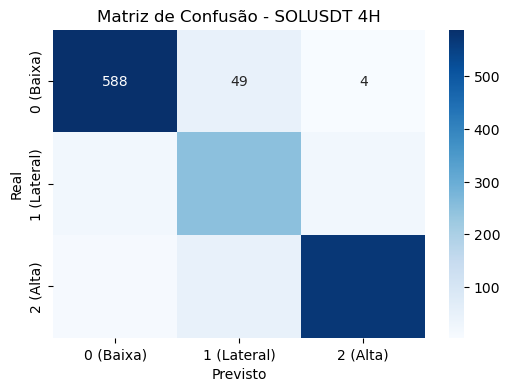


🚀 Iniciando treino para BYBIT - SOLUSDT 1D (Total de 1267 linhas)...

🚀 Treinando modelo para SOLUSDT 1D...
✅ SOLUSDT 1D - Acurácia: 0.9764

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.98      1.00      0.99        98
 1 (Lateral)       0.95      0.95      0.95        64
    2 (Alta)       0.99      0.97      0.98        92

    accuracy                           0.98       254
   macro avg       0.97      0.97      0.97       254
weighted avg       0.98      0.98      0.98       254



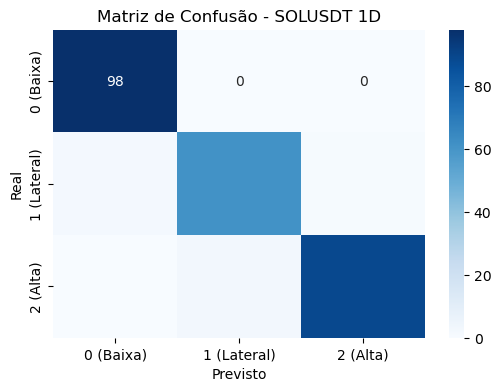


🚀 Iniciando treino para BYBIT - ETHUSDT 1H (Total de 37541 linhas)...

🚀 Treinando modelo para ETHUSDT 1H...
✅ ETHUSDT 1H - Acurácia: 0.9029

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.96      0.91      0.93      2858
 1 (Lateral)       0.71      0.86      0.78      1465
    2 (Alta)       0.96      0.92      0.94      3186

    accuracy                           0.90      7509
   macro avg       0.88      0.90      0.88      7509
weighted avg       0.91      0.90      0.91      7509



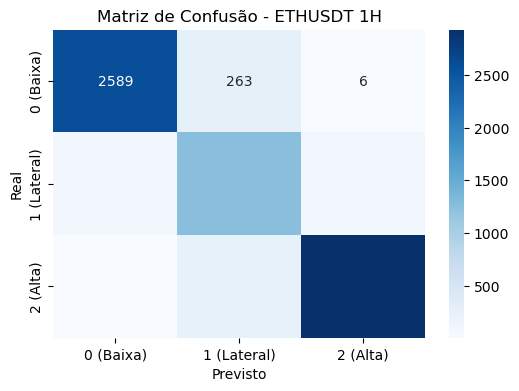


🚀 Iniciando treino para BYBIT - ETHUSDT 4H (Total de 9349 linhas)...

🚀 Treinando modelo para ETHUSDT 4H...
✅ ETHUSDT 4H - Acurácia: 0.9160

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.95      0.93      0.94       712
 1 (Lateral)       0.76      0.84      0.80       334
    2 (Alta)       0.96      0.93      0.95       824

    accuracy                           0.92      1870
   macro avg       0.89      0.90      0.90      1870
weighted avg       0.92      0.92      0.92      1870



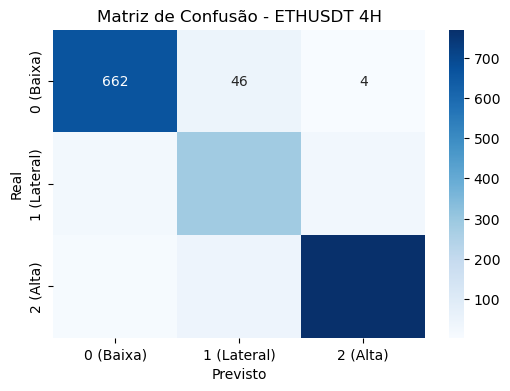


🚀 Iniciando treino para BYBIT - ETHUSDT 1D (Total de 1518 linhas)...

🚀 Treinando modelo para ETHUSDT 1D...
✅ ETHUSDT 1D - Acurácia: 0.9507

📊 📌 Classification Report:
              precision    recall  f1-score   support

   0 (Baixa)       0.98      0.97      0.97        99
 1 (Lateral)       0.90      0.85      0.87        61
    2 (Alta)       0.95      0.98      0.97       144

    accuracy                           0.95       304
   macro avg       0.94      0.93      0.94       304
weighted avg       0.95      0.95      0.95       304



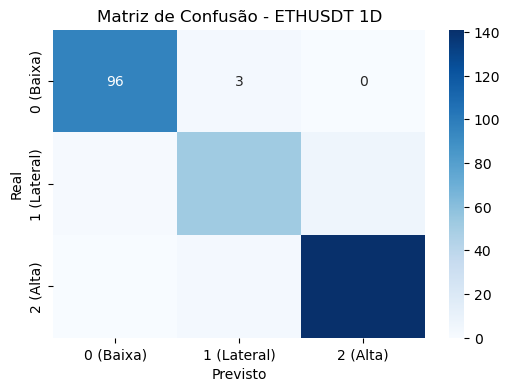


📊 📌 Resumo Final de Acurácias:
BINANCE_BTCUSDT_1H: ✅ Acurácia 0.8945
BINANCE_BTCUSDT_4H: ✅ Acurácia 0.9157
BINANCE_BTCUSDT_1D: ✅ Acurácia 0.9819
BINANCE_SOLUSDT_1H: ✅ Acurácia 0.9066
BINANCE_SOLUSDT_4H: ✅ Acurácia 0.8830
BINANCE_SOLUSDT_1D: ✅ Acurácia 0.9550
BINANCE_ETHUSDT_1H: ✅ Acurácia 0.8970
BINANCE_ETHUSDT_4H: ✅ Acurácia 0.9002
BINANCE_ETHUSDT_1D: ✅ Acurácia 0.9703
BYBIT_BTCUSDT_1H: ✅ Acurácia 0.9001
BYBIT_BTCUSDT_4H: ✅ Acurácia 0.9166
BYBIT_BTCUSDT_1D: ✅ Acurácia 0.9624
BYBIT_SOLUSDT_1H: ✅ Acurácia 0.9129
BYBIT_SOLUSDT_4H: ✅ Acurácia 0.8974
BYBIT_SOLUSDT_1D: ✅ Acurácia 0.9764
BYBIT_ETHUSDT_1H: ✅ Acurácia 0.9029
BYBIT_ETHUSDT_4H: ✅ Acurácia 0.9160
BYBIT_ETHUSDT_1D: ✅ Acurácia 0.9507


In [31]:
model_results = {}

for key, df in cleaned_results.items():
    exchange, asset, timeframe = key.split('_')

    print(f"\n🚀 Iniciando treino para {exchange} - {asset} {timeframe} (Total de {df.shape[0]} linhas)...")

    # Treinar e armazenar o modelo e métricas
    model_results[key] = train_and_evaluate(asset, timeframe, df)

# Exibir resumo das acurácias
print("\n📊 📌 Resumo Final de Acurácias:")
for key, result in model_results.items():
    if result is not None:
        print(f"{key}: ✅ Acurácia {result['accuracy']:.4f}")
    else:
        print(f"{key}: ❌ Não treinado")

